In [220]:
#imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy import sparse
from pandas.api.types import CategoricalDtype
from tqdm import tqdm 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


# Project 3 | Matrix Factorization Methods 

## Jester Joke Data
2.5 million anonymous ratings of jokes by users of the Jester Joke Recommender System (Ken Goldberg, AUTOLab, UC Berkeley).  Values from (-10.00 to +10.00) of 100 jokes collected between April 1999 - May 2003.  Data from 24,983 users who have rated 36 or more jokes, a matrix with dimensions 24983 X 101. 

In [2]:
#import joke data
original_jokes_df = pd.read_csv('jester-data-1.csv')

In [3]:
original_jokes_df

,User,Number of Jokes Rated,1,2,3,4,5,6,7,8,...,91,92,93,94,95,96,97,98,99,100
0,1,74.0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,...,2.82,NaN,NaN,NaN,NaN,NaN,-5.63,NaN,NaN,NaN
1,2,100.0,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,3,49.0,NaN,NaN,NaN,NaN,9.03,9.27,9.03,9.27,...,NaN,NaN,NaN,9.08,NaN,NaN,NaN,NaN,NaN,NaN
3,4,48.0,NaN,8.35,NaN,NaN,1.80,8.16,-2.82,6.21,...,NaN,NaN,NaN,0.53,NaN,NaN,NaN,NaN,NaN,NaN
4,5,91.0,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,24979,100.0,0.44,7.43,9.08,2.33,3.20,6.75,-8.79,-0.53,...,8.83,-1.21,9.22,-6.70,8.45,9.03,6.55,8.69,8.79,7.43
24979,24980,91.0,9.13,-8.16,8.59,9.08,0.87,-8.93,-3.50,5.78,...,-1.17,-5.73,-1.46,0.24,9.22,-8.20,-7.23,-8.59,9.13,8.45
24980,24981,39.0,NaN,NaN,NaN,NaN,-7.77,NaN,6.70,-6.75,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24981,24982,37.0,NaN,NaN,NaN,NaN,-9.71,NaN,4.56,-8.30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [98]:
jokes_long_df = pd.melt(original_jokes_df.drop(columns=['Number of Jokes Rated']), id_vars=['User'])
jokes_long_df = jokes_df.rename(columns={"User": "user_id", "variable": "item_id", "value":"rating"})
jokes_long_df

,user_id,item_id,rating
0,1,1,-7.82
1,2,1,4.08
2,3,1,NaN
3,4,1,NaN
4,5,1,8.50
...,...,...,...
2498295,24979,100,7.43
2498296,24980,100,8.45
2498297,24981,100,NaN
2498298,24982,100,NaN


### Sparseness 
This dataset is relatively sparse. There are alot of jokes that users did not rate. High portion of missing values caused by sparseness in the user-item ratings matrix. Carelessly addressing only the relatively few known entries is highly prone to overfitting. Previously, I had used a dense subcluster to approximate user similarity. SVD requires that there are no missing values. ALS can handle missing values.

#### Rescaled to a 1 to 10 scale, so that i turn my nans into 0s so i can use the CSR matrix

In [126]:
jokes_df = original_jokes_df.drop(columns=['Number of Jokes Rated']).copy()

In [127]:
min_rating = jokes_df.drop(columns=['User']).min().min()
max_rating = jokes_df.drop(columns=['User']).max().max()

def rescale(x):
    return 1 + 9 * (x - min_rating) / (max_rating - min_rating)

df_rescaled = jokes_df.drop(columns=['User']).apply(lambda row: 1 + 9 * (row - row.min()) / (row.max() - row.min()), axis=1)

df_rescaled = df_rescaled.fillna(0)

In [185]:
df_rescaled

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,1.962592,9.838778,1.090095,1.801370,2.104847,1.640148,1.000000,7.648051,1.412540,3.413593,...,7.007903,0.000000,0.000000,0.000000,0.000000,0.000000,3.001054,0.000000,0.000000,0.000000
1,7.549788,5.466631,8.636653,7.688030,4.470339,1.000000,5.256886,3.059322,9.837924,10.000000,...,6.949153,3.245233,5.466631,9.351695,5.514301,4.584746,7.063559,5.766949,3.545551,6.114936
2,0.000000,0.000000,0.000000,0.000000,9.822403,9.947766,9.822403,9.947766,0.000000,0.000000,...,0.000000,0.000000,0.000000,9.848520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,10.000000,0.000000,0.000000,6.459459,9.897297,3.962162,8.843243,0.000000,6.481081,...,0.000000,0.000000,0.000000,5.772973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,9.791824,7.908553,3.657881,3.067240,6.335126,6.451318,9.084992,7.908553,5.463690,8.450780,...,8.189349,8.378160,7.743948,8.189349,8.450780,6.427111,7.182356,8.847768,6.548144,6.451318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24978,5.865245,9.138398,9.911030,6.750260,7.157648,8.819979,1.543184,5.411030,1.566597,9.044745,...,9.793965,5.092612,9.976587,2.521852,9.616025,9.887617,8.726327,9.728408,9.775234,9.138398
24979,9.931670,1.492950,9.668113,9.907267,5.900217,1.117137,3.767354,8.296638,1.517354,7.867137,...,4.904555,2.678959,4.763015,5.592733,9.975597,1.473427,1.946855,1.283080,9.931670,9.599783
24980,0.000000,0.000000,0.000000,0.000000,1.053150,0.000000,9.598425,1.655512,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
24981,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,8.131038,1.704609,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [150]:
sparse_matrix = csr_matrix(df_rescaled.values)

In [155]:
df_rescaled.values

array([[1.9625922 , 9.83877766, 1.09009484, ..., 0.        , 0.        ,
        0.        ],
       [7.54978814, 5.46663136, 8.63665254, ..., 5.76694915, 3.54555085,
        6.11493644],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [6.74728261, 6.86467391, 3.61195652, ..., 0.        , 0.        ,
        0.        ]])

In [151]:
sparse_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1810172 stored elements and shape (24983, 100)>

In [152]:
print("\ndata:", sparse_matrix.data)
print("indices:", sparse_matrix.indices)
print("indptr:", sparse_matrix.indptr)


data: [1.9625922  9.83877766 1.09009484 ... 7.12391304 8.62065217 9.0951087 ]
indices: [ 0  1  2 ... 69 70 86]
indptr: [      0      74     174 ... 1810063 1810100 1810172]


In [153]:
# sparse memory usage (in bytes)
original = df_rescaled.memory_usage(deep=True).sum()

# CSR memory usage
nnz = sparse_matrix.nnz  # number of non-zero elements
csr_data_mem = nnz * 8         # float64
csr_indices_mem = nnz * 4      # int32
csr_indptr_mem = (sparse_matrix.shape[0] + 1) * 4  # int32
csr_mem = csr_data_mem + csr_indices_mem + csr_indptr_mem

# Calculate storage reduction
reduction = 1 - (csr_mem / original)

#### Storage Reduction:
I'm surprised my storage usage is somehow worse using CSR? I guess the jokes df is less sparse than i had expected, and CSR added space w/ extra added reference indexes? It looks like CSR is not worth it in this case for memory saving uses?

In [156]:
# Print results
print(f"Original memory usage: {original / 1024**2:.2f} MB")
print(f"CSR memory usage:   {csr_mem / 1024**2:.2f} MB")
print(f"Storage reduction:  {reduction * 100:.2f}%")

Original memory usage: 19.06 MB
CSR memory usage:   20.81 MB
Storage reduction:  -9.18%


In [160]:
# Total number of elements
total_elements = df_rescaled.size
# Count number of explicit zeros
num_zeros = (df_rescaled == 0).sum().sum()
# Count of non-sparse (stored) values (i.e. not NaN and not 0)
num_non_sparse = total_elements - num_zeros
# Calculate sparsity
sparsity = num_zeros / total_elements
density = num_non_sparse / total_elements

print(f"Total elements: {total_elements}")
print(f"Zero values: {num_zeros}")
print(f"Sparsity: {sparsity:.2%}")
print(f"Density (non-sparse): {density:.2%}")

Total elements: 2498300
Zero values: 688128
Sparsity: 27.54%
Density (non-sparse): 72.46%


## Alternating Least Squares 
Alternating Least Squares (ALS) is a matrix factorization algorithm used primarily in recommendation systems to uncover hidden (latent) patterns between users and items, even when many ratings are missing. In this case, ALS works by fixing the user matrix, then solving for the joke matrix, then fixing the other, solving again, and repeating until both sides converge. This minimizes the regularized squared error on the set of known rating. 

In [230]:
def matrix_factorization_als(R, k=10, max_iter=100, reg=0.1, tol=1e-6):
        """
        Perform matrix factorization using Alternating Least Squares
        R: ratings matrix (sparse, 0 means missing)
        k: number of latent factors
        """
        n_users, n_jokes = R.shape
        
        # Initialize factors randomly
        U = np.random.normal(0, 0.1, (n_users, k))
        V = np.random.normal(0, 0.1, (n_jokes, k))
        
        # Get positions of known ratings
        known_ratings = R != 0
        
        prev_error = float('inf')
    
        for iteration in range(max_iter):
            # Update U (user factors)
            for i in range(n_users):
                rated_jokes = known_ratings[i, :]
                if np.any(rated_jokes):
                    V_rated = V[rated_jokes, :]
                    ratings = R[i, rated_jokes]
                    
                    # Solve: U[i] = argmin ||ratings - U[i] @ V_rated.T||^2 + reg * ||U[i]||^2
                    A = V_rated.T @ V_rated + reg * np.eye(k)
                    b = V_rated.T @ ratings
                    U[i, :] = np.linalg.solve(A, b)
            
            # Update V (movie factors)
            for j in range(n_jokes):
                rating_users = known_ratings[:, j]
                if np.any(rating_users):
                    U_rating = U[rating_users, :]
                    ratings = R[rating_users, j]
                    
                    # Solve: V[j] = argmin ||ratings - U_rating @ V[j]||^2 + reg * ||V[j]||^2
                    A = U_rating.T @ U_rating + reg * np.eye(k)
                    b = U_rating.T @ ratings
                    V[j, :] = np.linalg.solve(A, b)
            
            # Calculate error on known ratings
            predicted = U @ V.T
            error = np.mean((R[known_ratings] - predicted[known_ratings])**2)
            
            if iteration % 20 == 0:
                print(f"  Iteration {iteration}: RMSE = {np.sqrt(error):.4f}")
            
            if abs(prev_error - error) < tol:
                print(f"  Converged after {iteration} iterations")
                break
            
            prev_error = error
        
        return U, V, predicted, prev_error

In [205]:
U_als, V_als, predicted_als = matrix_factorization_als(df_rescaled.head(1000).values, k=10, max_iter=101)

  Iteration 0: RMSE = 2.2664
  Iteration 10: RMSE = 1.8561
  Iteration 20: RMSE = 1.8505
  Iteration 30: RMSE = 1.8488
  Iteration 40: RMSE = 1.8477
  Iteration 50: RMSE = 1.8468
  Iteration 60: RMSE = 1.8464
  Iteration 70: RMSE = 1.8463
  Iteration 80: RMSE = 1.8463
  Iteration 90: RMSE = 1.8463
  Iteration 100: RMSE = 1.8462


In [197]:
predicted_als

array([[ 4.79221366,  6.43944177,  0.62007048, ...,  4.0472152 ,
         2.62950896,  3.23958452],
       [ 7.38173046,  5.38366328,  9.54874573, ...,  6.18243653,
         5.4271954 ,  8.48065572],
       [11.46102867,  9.85343536, 11.4048486 , ...,  8.36477267,
         9.04364887,  9.03258766],
       ...,
       [ 9.08050687,  7.69678793,  9.3062668 , ...,  5.19807932,
         4.16269152,  7.13443578],
       [ 1.60577536,  1.78084589,  0.9207565 , ...,  3.02549563,
         1.87029264,  3.59890195],
       [ 5.38992124,  5.58252489,  2.81495227, ...,  6.01944348,
         7.40664854,  5.75430949]])

### Trying different k values:
k is the number of latent features.
Larger k is a more expressive model (can capture more nuance).
Smaller k is a simpler model (less prone to overfitting, faster).

Calculating the matrices can be computationally expensive, although calculating ratings once the factorization is completed is very fast. You may need to create a subset of your data for calculations to be successfully performed, especially on a machine with a small RAM footprint

In [223]:
#df
R = df_rescaled.head(1000).values
mask = ~np.isnan(R)

# List of k values to try
k_values = [2, 5, 10, 20, 50, 100]
rmses = []

for k in tqdm(k_values, desc="Trying different k values"):
    U, V, predicted, prev_error = matrix_factorization_als(true_values, k=k, max_iter=101)
    rmses.append(prev_error)

Trying different k values:   0%|          | 0/6 [00:00<?, ?it/s]

  Iteration 0: RMSE = 3.2468
  Iteration 10: RMSE = 2.1928
  Iteration 20: RMSE = 2.1927
  Iteration 30: RMSE = 2.1926
  Iteration 40: RMSE = 2.1926
  Iteration 50: RMSE = 2.1926
  Iteration 60: RMSE = 2.1926
  Iteration 70: RMSE = 2.1926
  Converged after 70 iterations


Trying different k values:  17%|█▋        | 1/6 [00:06<00:31,  6.20s/it]

  Iteration 0: RMSE = 2.6644
  Iteration 10: RMSE = 2.0203
  Iteration 20: RMSE = 2.0201
  Iteration 30: RMSE = 2.0201
  Iteration 40: RMSE = 2.0201
  Iteration 50: RMSE = 2.0200
  Iteration 60: RMSE = 2.0200
  Iteration 70: RMSE = 2.0200
  Iteration 80: RMSE = 2.0200
  Iteration 90: RMSE = 2.0200
  Iteration 100: RMSE = 2.0200


Trying different k values:  33%|███▎      | 2/6 [00:15<00:33,  8.28s/it]

  Iteration 0: RMSE = 2.3711
  Iteration 10: RMSE = 1.8508
  Iteration 20: RMSE = 1.8474
  Iteration 30: RMSE = 1.8467
  Iteration 40: RMSE = 1.8465
  Iteration 50: RMSE = 1.8464
  Iteration 60: RMSE = 1.8463
  Iteration 70: RMSE = 1.8463
  Iteration 80: RMSE = 1.8463
  Iteration 90: RMSE = 1.8462
  Iteration 100: RMSE = 1.8462


Trying different k values:  50%|█████     | 3/6 [00:28<00:30, 10.06s/it]

  Iteration 0: RMSE = 2.1204
  Iteration 10: RMSE = 1.5793
  Iteration 20: RMSE = 1.5700
  Iteration 30: RMSE = 1.5656
  Iteration 40: RMSE = 1.5634
  Iteration 50: RMSE = 1.5620
  Iteration 60: RMSE = 1.5609
  Iteration 70: RMSE = 1.5601
  Iteration 80: RMSE = 1.5595
  Iteration 90: RMSE = 1.5590
  Iteration 100: RMSE = 1.5587


Trying different k values:  67%|██████▋   | 4/6 [01:11<00:46, 23.17s/it]

  Iteration 0: RMSE = 1.4207
  Iteration 10: RMSE = 0.8933
  Iteration 20: RMSE = 0.8646
  Iteration 30: RMSE = 0.8526
  Iteration 40: RMSE = 0.8460
  Iteration 50: RMSE = 0.8418
  Iteration 60: RMSE = 0.8388
  Iteration 70: RMSE = 0.8367
  Iteration 80: RMSE = 0.8351
  Iteration 90: RMSE = 0.8337
  Iteration 100: RMSE = 0.8327


Trying different k values:  83%|████████▎ | 5/6 [02:32<00:44, 44.08s/it]

  Iteration 0: RMSE = 0.0770
  Iteration 10: RMSE = 0.0082
  Iteration 20: RMSE = 0.0049
  Converged after 27 iterations


Trying different k values: 100%|██████████| 6/6 [03:53<00:00, 38.95s/it]


## Evaluate the effectiveness of the matrix factorization model:
By assessing the quality of predictions using performance metrics such as RMSE, and comparing these results with those from
baseline models.  

Root-Mean-Square Error
		○ While we can pick among several measures of how close the product UV is to M, the typical choice is the root-mean-square error (RMSE), where we
			i. Sum, over all nonblank entries in M the square of the difference between that entry and the corresponding entry in the product UV .
			ii. Take the mean (average) of these squares by dividing by the number of terms in the sum (i.e., the number of nonblank entries in M).
			iii. Take the square root of the mean

Local Minima:
		○ Matrices U and V such that no allowable adjustment reduces the RMSE
		○ Global Minimum – Unfortunately, only one of these local minima will be the matrices U and V that produce the least possible RMSE
There is never a guarantee that our best local minimum will be the global minimum.

### Avoiding Overfitting
Although the RMSE may be small on the given data, it doesn’t mean it will do well predicting future data. UV-decomposition is that we arrive at one of the many local minima that conform well to the given data, but picks up values in the data that don’t reflect well the underlying process that gives rise to the data. We want to stop revisiting elements of U and V well before the process has converged with early stopping to prevent this.

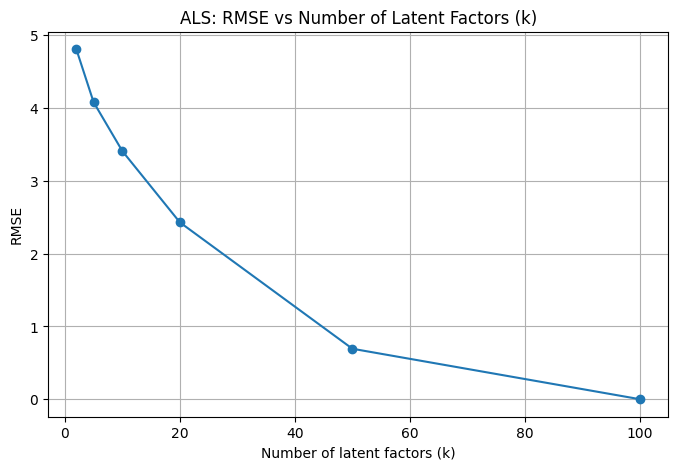

In [224]:
# Plotting RMSE vs k
plt.figure(figsize=(8,5))
plt.plot(k_values, rmses, marker='o')
plt.title('ALS: RMSE vs Number of Latent Factors (k)')
plt.xlabel('Number of latent factors (k)')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

In [255]:
U_als, V_als, predicted_als, prev_error  = matrix_factorization_als(df_rescaled.head(1000).values, k=40, max_iter=41)

  Iteration 0: RMSE = 1.6071
  Iteration 20: RMSE = 1.0835
  Iteration 40: RMSE = 1.0665


In [244]:
df_rescaled.head(1000).values

array([[ 1.9625922 ,  9.83877766,  1.09009484, ...,  0.        ,
         0.        ,  0.        ],
       [ 7.54978814,  5.46663136,  8.63665254, ...,  5.76694915,
         3.54555085,  6.11493644],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 9.96577947, 10.        ,  9.4661597 , ...,  0.        ,
         0.        ,  0.        ],
       [ 1.42752741,  2.28258222,  1.42752741, ...,  1.53714982,
         1.53714982,  1.        ],
       [ 3.59048362,  4.88923557,  3.0850234 , ...,  0.        ,
         0.        ,  0.        ]])

In [260]:
df_rescaled.head(1000)

,1,2,3,4,5,6,7,8,9,10,...,91,92,93,94,95,96,97,98,99,100
0,1.962592,9.838778,1.090095,1.801370,2.104847,1.640148,1.000000,7.648051,1.412540,3.413593,...,7.007903,0.000000,0.000000,0.000000,0.000000,0.000000,3.001054,0.000000,0.000000,0.000000
1,7.549788,5.466631,8.636653,7.688030,4.470339,1.000000,5.256886,3.059322,9.837924,10.000000,...,6.949153,3.245233,5.466631,9.351695,5.514301,4.584746,7.063559,5.766949,3.545551,6.114936
2,0.000000,0.000000,0.000000,0.000000,9.822403,9.947766,9.822403,9.947766,0.000000,0.000000,...,0.000000,0.000000,0.000000,9.848520,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,10.000000,0.000000,0.000000,6.459459,9.897297,3.962162,8.843243,0.000000,6.481081,...,0.000000,0.000000,0.000000,5.772973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,9.791824,7.908553,3.657881,3.067240,6.335126,6.451318,9.084992,7.908553,5.463690,8.450780,...,8.189349,8.378160,7.743948,8.189349,8.450780,6.427111,7.182356,8.847768,6.548144,6.451318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,7.112767,2.755671,9.008425,2.779002,3.601426,4.511342,7.847699,8.215165,2.469864,7.707712,...,3.403111,5.357097,8.530136,4.167207,7.567725,3.572262,7.281918,2.755671,8.046014,7.369410
996,7.843902,5.951220,8.390244,3.014634,4.009756,8.482927,6.331707,1.780488,2.897561,2.492683,...,0.000000,0.000000,0.000000,0.000000,3.604878,0.000000,0.000000,0.000000,0.000000,0.000000
997,9.965779,10.000000,9.466160,4.018251,8.473764,5.284411,8.569582,7.611407,2.957414,6.680608,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
998,1.427527,2.282582,1.427527,1.427527,7.708892,5.790499,1.635810,2.227771,1.427527,2.808770,...,1.591961,4.935445,4.935445,1.537150,1.537150,1.537150,1.537150,1.537150,1.537150,1.000000


### Top 5 Jokes User 2 hasn't rated:

In [261]:
# Pick a user index (e.g., 0 for the first user)
user_id = 2

# Get the user's predicted ratings
user_pred_ratings = predicted_als[user_id]

# Get the items the user has already rated
rated_items_mask = ~np.isnan(df_rescaled.head(1000).iloc[user_id].values)

# Get indices of top 5 recommended items
top5_item_indices = np.argsort(user_pred_ratings)[-5:][::-1]

# Map indices back to item names (column labels)
top5_item_names = df_rescaled.columns[top5_item_indices]

# Print results
print(f"Top 5 recommended items for user {user_id}:")
for i, item in enumerate(top5_item_names, 1):
    print(f"{i}. {item} (predicted rating: {predicted_als[user_id, df_rescaled.columns.get_loc(item)]:.2f})")

Top 5 recommended items for user 2:
1. 71 (predicted rating: 18.82)
2. 2 (predicted rating: 17.60)
3. 59 (predicted rating: 14.92)
4. 93 (predicted rating: 14.81)
5. 73 (predicted rating: 14.23)



## Limitations and trade-offs of ALS

##### Hyperparameter Sensitivity
Performance heavily depends on: Number of latent factors (k). Regularization parameter (λ), Number of iterations. We need to tune it carefully, or it will underfit or overfit.

##### Lack of Interpretability
The latent factors learned by ALS are abstract, they don’t map directly to real-world concepts (like “dad jokes” or “dark  humor”).

##### Cold Start issues
Often a system must deal with the cold start problem, where in many users supply very few ratings. This dataset every user rated atleast 36 or more jokes, so it is less of an issue, but other datasets with less ratings per user may havw to find a way to incorporate additional sources of information about the users. 